In [96]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})



In [97]:
summary = pd.read_csv("../PCCArena/experiments/summary.csv")
summary.datasets.unique()
display(summary)

,algs,datasets,rate,pc_file,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,CAPOD,r1,/itf-fi-ml/home/branisj/PCCArena/experiments/D...,0.3245,0.3280,0.021056,NaN,NaN,NaN,...,3406.08,274.323,421.742,348.033,35.6711,1905.75,NaN,NaN,NaN,NaN
1,Draco,CAPOD,r1,/itf-fi-ml/home/branisj/PCCArena/experiments/D...,0.2280,0.2392,0.023488,NaN,NaN,NaN,...,3431.90,296.324,447.470,371.897,35.9726,2381.31,NaN,NaN,NaN,NaN
2,Draco,CAPOD,r1,/itf-fi-ml/home/branisj/PCCArena/experiments/D...,0.2039,0.2273,0.019152,NaN,NaN,NaN,...,3391.87,228.646,354.523,291.585,36.5307,1733.04,NaN,NaN,NaN,NaN
3,Draco,CAPOD,r1,/itf-fi-ml/home/branisj/PCCArena/experiments/D...,0.3464,0.2711,0.027408,NaN,NaN,NaN,...,3433.25,365.082,439.821,402.451,35.6227,2310.47,NaN,NaN,NaN,NaN
4,Draco,CAPOD,r1,/itf-fi-ml/home/branisj/PCCArena/experiments/D...,0.2349,0.2704,0.019312,NaN,NaN,NaN,...,3423.57,146.157,377.379,261.768,36.5335,1782.18,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16521,PCGCv1,s3dis,r1,/itf-fi-ml/home/branisj/PCCArena/experiments/P...,27.2772,27.2866,0.386807,NaN,NaN,NaN,...,2484.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16522,VPCC,Debug_SNCC,r1,/itf-fi-ml/home/branisj/PCCArena/experiments/V...,-1.0000,-1.0000,4.535361,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16523,VPCC,Debug_SNCC,r1,/itf-fi-ml/home/branisj/PCCArena/experiments/V...,-1.0000,-1.0000,1.290955,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16524,VPCC,Debug_SNCC,r1,/itf-fi-ml/home/branisj/PCCArena/experiments/V...,-1.0000,-1.0000,0.261178,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'CAPOD'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,0.281811,0.360525,0.019388,NaN,NaN,NaN,NaN,NaN,...,3431.352222,260.952864,590.784311,425.868550,34.932662,2693.204889,NaN,NaN,NaN,NaN
1,Draco,r2,0.279204,0.286847,0.063953,NaN,NaN,NaN,NaN,NaN,...,804.964828,72.746009,139.873975,106.310005,40.838544,679.726339,NaN,NaN,NaN,NaN
2,Draco,r3,0.316915,0.285464,0.200763,NaN,NaN,NaN,NaN,NaN,...,194.939261,19.210067,33.616226,26.413144,46.826936,170.160422,NaN,NaN,NaN,NaN
3,Draco,r4,0.365311,0.291973,0.510357,NaN,NaN,NaN,NaN,NaN,...,47.957558,5.069270,8.155571,6.612421,52.803458,42.658565,NaN,NaN,NaN,NaN
4,Draco,r5,0.392363,0.307360,1.216532,NaN,NaN,NaN,NaN,NaN,...,11.904297,1.257298,1.810104,1.533701,59.174113,10.658272,NaN,NaN,NaN,NaN
5,Draco,r6,0.466878,0.343593,2.675782,NaN,NaN,NaN,NaN,NaN,...,2.964724,0.332637,0.398977,0.365807,65.352929,2.656472,NaN,NaN,NaN,NaN
6,Draco,r7,0.639237,0.385119,4.975870,NaN,NaN,NaN,NaN,NaN,...,0.739195,0.082715,0.087562,0.085138,71.676533,0.660940,NaN,NaN,NaN,NaN
7,Draco,r8,0.654037,0.413642,7.715475,NaN,NaN,NaN,NaN,NaN,...,0.184711,0.020682,0.020988,0.020835,77.789392,0.164784,NaN,NaN,NaN,NaN
8,GPCC,r1,2.768721,0.321466,0.079316,NaN,NaN,NaN,NaN,NaN,...,47.348427,5.010585,8.072183,6.541385,52.850223,42.053263,NaN,NaN,NaN,NaN
9,GPCC,r2,1.961028,0.935261,0.342156,NaN,NaN,NaN,NaN,NaN,...,11.830072,1.286861,1.836339,1.561600,59.066241,10.572372,NaN,NaN,NaN,NaN


's3dis'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,0.524926,0.332054,0.711935,NaN,NaN,NaN,NaN,NaN,...,2924.346680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Draco,r2,0.375914,0.317789,0.102039,NaN,NaN,NaN,NaN,NaN,...,804.037396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Draco,r3,0.432032,0.296542,0.271169,NaN,NaN,NaN,NaN,NaN,...,195.063630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Draco,r4,0.466861,0.292182,0.606070,NaN,NaN,NaN,NaN,NaN,...,48.053825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Draco,r5,0.531143,0.312787,1.376839,NaN,NaN,NaN,NaN,NaN,...,11.896520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Draco,r6,0.642891,0.366756,2.848240,NaN,NaN,NaN,NaN,NaN,...,2.966486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Draco,r7,0.730538,0.411037,4.921021,NaN,NaN,NaN,NaN,NaN,...,0.739921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Draco,r8,0.873445,0.476163,7.291800,NaN,NaN,NaN,NaN,NaN,...,0.184863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GPCC,r1,1.723626,0.270578,0.076305,NaN,NaN,NaN,NaN,NaN,...,45.493354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GPCC,r2,3.039493,1.361625,0.413686,NaN,NaN,NaN,NaN,NaN,...,11.840335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'blensor'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,3.333493,0.545417,3.666874,NaN,NaN,NaN,NaN,NaN,...,3427.531404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Draco,r2,2.151701,0.625529,4.968020,NaN,NaN,NaN,NaN,NaN,...,806.680899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Draco,r3,2.019900,0.637353,6.739484,NaN,NaN,NaN,NaN,NaN,...,195.434930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Draco,r4,2.052198,0.710376,9.028216,NaN,NaN,NaN,NaN,NaN,...,48.121461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Draco,r5,1.913347,0.706250,11.754646,NaN,NaN,NaN,NaN,NaN,...,11.940971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Draco,r6,2.110687,0.745154,14.762841,NaN,NaN,NaN,NaN,NaN,...,2.972987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Draco,r7,2.276248,0.777128,17.865314,NaN,NaN,NaN,NaN,NaN,...,0.741212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Draco,r8,2.404014,0.747929,20.958048,NaN,NaN,NaN,NaN,NaN,...,0.185221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GPCC,r1,4.384853,0.954776,0.193981,NaN,NaN,NaN,NaN,NaN,...,47.450979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GPCC,r2,6.000692,3.331211,0.931893,NaN,NaN,NaN,NaN,NaN,...,11.863436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'CAPOD'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,0.281811,0.360525,0.019388,NaN,NaN,NaN,NaN,NaN,...,3431.352222,260.952864,590.784311,425.868550,34.932662,2693.204889,NaN,NaN,NaN,NaN
1,Draco,r2,0.279204,0.286847,0.063953,NaN,NaN,NaN,NaN,NaN,...,804.964828,72.746009,139.873975,106.310005,40.838544,679.726339,NaN,NaN,NaN,NaN
2,Draco,r3,0.316915,0.285464,0.200763,NaN,NaN,NaN,NaN,NaN,...,194.939261,19.210067,33.616226,26.413144,46.826936,170.160422,NaN,NaN,NaN,NaN
3,Draco,r4,0.365311,0.291973,0.510357,NaN,NaN,NaN,NaN,NaN,...,47.957558,5.069270,8.155571,6.612421,52.803458,42.658565,NaN,NaN,NaN,NaN
4,Draco,r5,0.392363,0.307360,1.216532,NaN,NaN,NaN,NaN,NaN,...,11.904297,1.257298,1.810104,1.533701,59.174113,10.658272,NaN,NaN,NaN,NaN
5,Draco,r6,0.466878,0.343593,2.675782,NaN,NaN,NaN,NaN,NaN,...,2.964724,0.332637,0.398977,0.365807,65.352929,2.656472,NaN,NaN,NaN,NaN
6,Draco,r7,0.639237,0.385119,4.975870,NaN,NaN,NaN,NaN,NaN,...,0.739195,0.082715,0.087562,0.085138,71.676533,0.660940,NaN,NaN,NaN,NaN
7,Draco,r8,0.654037,0.413642,7.715475,NaN,NaN,NaN,NaN,NaN,...,0.184711,0.020682,0.020988,0.020835,77.789392,0.164784,NaN,NaN,NaN,NaN
8,GPCC,r1,2.768721,0.321466,0.079316,NaN,NaN,NaN,NaN,NaN,...,47.348427,5.010585,8.072183,6.541385,52.850223,42.053263,NaN,NaN,NaN,NaN
9,GPCC,r2,1.961028,0.935261,0.342156,NaN,NaN,NaN,NaN,NaN,...,11.830072,1.286861,1.836339,1.561600,59.066241,10.572372,NaN,NaN,NaN,NaN


's3dis'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,0.524926,0.332054,0.711935,NaN,NaN,NaN,NaN,NaN,...,2924.346680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Draco,r2,0.375914,0.317789,0.102039,NaN,NaN,NaN,NaN,NaN,...,804.037396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Draco,r3,0.432032,0.296542,0.271169,NaN,NaN,NaN,NaN,NaN,...,195.063630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Draco,r4,0.466861,0.292182,0.606070,NaN,NaN,NaN,NaN,NaN,...,48.053825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Draco,r5,0.531143,0.312787,1.376839,NaN,NaN,NaN,NaN,NaN,...,11.896520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Draco,r6,0.642891,0.366756,2.848240,NaN,NaN,NaN,NaN,NaN,...,2.966486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Draco,r7,0.730538,0.411037,4.921021,NaN,NaN,NaN,NaN,NaN,...,0.739921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Draco,r8,0.873445,0.476163,7.291800,NaN,NaN,NaN,NaN,NaN,...,0.184863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GPCC,r1,1.723626,0.270578,0.076305,NaN,NaN,NaN,NaN,NaN,...,45.493354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GPCC,r2,3.039493,1.361625,0.413686,NaN,NaN,NaN,NaN,NaN,...,11.840335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'blensor'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,3.333493,0.545417,3.666874,NaN,NaN,NaN,NaN,NaN,...,3427.531404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Draco,r2,2.151701,0.625529,4.968020,NaN,NaN,NaN,NaN,NaN,...,806.680899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Draco,r3,2.019900,0.637353,6.739484,NaN,NaN,NaN,NaN,NaN,...,195.434930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Draco,r4,2.052198,0.710376,9.028216,NaN,NaN,NaN,NaN,NaN,...,48.121461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Draco,r5,1.913347,0.706250,11.754646,NaN,NaN,NaN,NaN,NaN,...,11.940971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Draco,r6,2.110687,0.745154,14.762841,NaN,NaN,NaN,NaN,NaN,...,2.972987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Draco,r7,2.276248,0.777128,17.865314,NaN,NaN,NaN,NaN,NaN,...,0.741212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Draco,r8,2.404014,0.747929,20.958048,NaN,NaN,NaN,NaN,NaN,...,0.185221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GPCC,r1,4.384853,0.954776,0.193981,NaN,NaN,NaN,NaN,NaN,...,47.450979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GPCC,r2,6.000692,3.331211,0.931893,NaN,NaN,NaN,NaN,NaN,...,11.863436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'CAPOD'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,0.281811,0.360525,0.019388,NaN,NaN,NaN,NaN,NaN,...,3431.352222,260.952864,590.784311,425.868550,34.932662,2693.204889,NaN,NaN,NaN,NaN
1,Draco,r2,0.279204,0.286847,0.063953,NaN,NaN,NaN,NaN,NaN,...,804.964828,72.746009,139.873975,106.310005,40.838544,679.726339,NaN,NaN,NaN,NaN
2,Draco,r3,0.316915,0.285464,0.200763,NaN,NaN,NaN,NaN,NaN,...,194.939261,19.210067,33.616226,26.413144,46.826936,170.160422,NaN,NaN,NaN,NaN
3,Draco,r4,0.365311,0.291973,0.510357,NaN,NaN,NaN,NaN,NaN,...,47.957558,5.069270,8.155571,6.612421,52.803458,42.658565,NaN,NaN,NaN,NaN
4,Draco,r5,0.392363,0.307360,1.216532,NaN,NaN,NaN,NaN,NaN,...,11.904297,1.257298,1.810104,1.533701,59.174113,10.658272,NaN,NaN,NaN,NaN
5,Draco,r6,0.466878,0.343593,2.675782,NaN,NaN,NaN,NaN,NaN,...,2.964724,0.332637,0.398977,0.365807,65.352929,2.656472,NaN,NaN,NaN,NaN
6,Draco,r7,0.639237,0.385119,4.975870,NaN,NaN,NaN,NaN,NaN,...,0.739195,0.082715,0.087562,0.085138,71.676533,0.660940,NaN,NaN,NaN,NaN
7,Draco,r8,0.654037,0.413642,7.715475,NaN,NaN,NaN,NaN,NaN,...,0.184711,0.020682,0.020988,0.020835,77.789392,0.164784,NaN,NaN,NaN,NaN
8,GPCC,r1,2.768721,0.321466,0.079316,NaN,NaN,NaN,NaN,NaN,...,47.348427,5.010585,8.072183,6.541385,52.850223,42.053263,NaN,NaN,NaN,NaN
9,GPCC,r2,1.961028,0.935261,0.342156,NaN,NaN,NaN,NaN,NaN,...,11.830072,1.286861,1.836339,1.561600,59.066241,10.572372,NaN,NaN,NaN,NaN


's3dis'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,0.524926,0.332054,0.711935,NaN,NaN,NaN,NaN,NaN,...,2924.346680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Draco,r2,0.375914,0.317789,0.102039,NaN,NaN,NaN,NaN,NaN,...,804.037396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Draco,r3,0.432032,0.296542,0.271169,NaN,NaN,NaN,NaN,NaN,...,195.063630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Draco,r4,0.466861,0.292182,0.606070,NaN,NaN,NaN,NaN,NaN,...,48.053825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Draco,r5,0.531143,0.312787,1.376839,NaN,NaN,NaN,NaN,NaN,...,11.896520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Draco,r6,0.642891,0.366756,2.848240,NaN,NaN,NaN,NaN,NaN,...,2.966486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Draco,r7,0.730538,0.411037,4.921021,NaN,NaN,NaN,NaN,NaN,...,0.739921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Draco,r8,0.873445,0.476163,7.291800,NaN,NaN,NaN,NaN,NaN,...,0.184863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GPCC,r1,1.723626,0.270578,0.076305,NaN,NaN,NaN,NaN,NaN,...,45.493354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GPCC,r2,3.039493,1.361625,0.413686,NaN,NaN,NaN,NaN,NaN,...,11.840335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'blensor'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,3.333493,0.545417,3.666874,NaN,NaN,NaN,NaN,NaN,...,3427.531404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Draco,r2,2.151701,0.625529,4.968020,NaN,NaN,NaN,NaN,NaN,...,806.680899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Draco,r3,2.019900,0.637353,6.739484,NaN,NaN,NaN,NaN,NaN,...,195.434930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Draco,r4,2.052198,0.710376,9.028216,NaN,NaN,NaN,NaN,NaN,...,48.121461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Draco,r5,1.913347,0.706250,11.754646,NaN,NaN,NaN,NaN,NaN,...,11.940971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Draco,r6,2.110687,0.745154,14.762841,NaN,NaN,NaN,NaN,NaN,...,2.972987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Draco,r7,2.276248,0.777128,17.865314,NaN,NaN,NaN,NaN,NaN,...,0.741212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Draco,r8,2.404014,0.747929,20.958048,NaN,NaN,NaN,NaN,NaN,...,0.185221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GPCC,r1,4.384853,0.954776,0.193981,NaN,NaN,NaN,NaN,NaN,...,47.450979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GPCC,r2,6.000692,3.331211,0.931893,NaN,NaN,NaN,NaN,NaN,...,11.863436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'CAPOD'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,0.281811,0.360525,0.019388,NaN,NaN,NaN,NaN,NaN,...,3431.352222,260.952864,590.784311,425.868550,34.932662,2693.204889,NaN,NaN,NaN,NaN
1,Draco,r2,0.279204,0.286847,0.063953,NaN,NaN,NaN,NaN,NaN,...,804.964828,72.746009,139.873975,106.310005,40.838544,679.726339,NaN,NaN,NaN,NaN
2,Draco,r3,0.316915,0.285464,0.200763,NaN,NaN,NaN,NaN,NaN,...,194.939261,19.210067,33.616226,26.413144,46.826936,170.160422,NaN,NaN,NaN,NaN
3,Draco,r4,0.365311,0.291973,0.510357,NaN,NaN,NaN,NaN,NaN,...,47.957558,5.069270,8.155571,6.612421,52.803458,42.658565,NaN,NaN,NaN,NaN
4,Draco,r5,0.392363,0.307360,1.216532,NaN,NaN,NaN,NaN,NaN,...,11.904297,1.257298,1.810104,1.533701,59.174113,10.658272,NaN,NaN,NaN,NaN
5,Draco,r6,0.466878,0.343593,2.675782,NaN,NaN,NaN,NaN,NaN,...,2.964724,0.332637,0.398977,0.365807,65.352929,2.656472,NaN,NaN,NaN,NaN
6,Draco,r7,0.639237,0.385119,4.975870,NaN,NaN,NaN,NaN,NaN,...,0.739195,0.082715,0.087562,0.085138,71.676533,0.660940,NaN,NaN,NaN,NaN
7,Draco,r8,0.654037,0.413642,7.715475,NaN,NaN,NaN,NaN,NaN,...,0.184711,0.020682,0.020988,0.020835,77.789392,0.164784,NaN,NaN,NaN,NaN
8,GPCC,r1,2.768721,0.321466,0.079316,NaN,NaN,NaN,NaN,NaN,...,47.348427,5.010585,8.072183,6.541385,52.850223,42.053263,NaN,NaN,NaN,NaN
9,GPCC,r2,1.961028,0.935261,0.342156,NaN,NaN,NaN,NaN,NaN,...,11.830072,1.286861,1.836339,1.561600,59.066241,10.572372,NaN,NaN,NaN,NaN


's3dis'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,0.524926,0.332054,0.711935,NaN,NaN,NaN,NaN,NaN,...,2924.346680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Draco,r2,0.375914,0.317789,0.102039,NaN,NaN,NaN,NaN,NaN,...,804.037396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Draco,r3,0.432032,0.296542,0.271169,NaN,NaN,NaN,NaN,NaN,...,195.063630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Draco,r4,0.466861,0.292182,0.606070,NaN,NaN,NaN,NaN,NaN,...,48.053825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Draco,r5,0.531143,0.312787,1.376839,NaN,NaN,NaN,NaN,NaN,...,11.896520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Draco,r6,0.642891,0.366756,2.848240,NaN,NaN,NaN,NaN,NaN,...,2.966486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Draco,r7,0.730538,0.411037,4.921021,NaN,NaN,NaN,NaN,NaN,...,0.739921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Draco,r8,0.873445,0.476163,7.291800,NaN,NaN,NaN,NaN,NaN,...,0.184863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GPCC,r1,1.723626,0.270578,0.076305,NaN,NaN,NaN,NaN,NaN,...,45.493354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GPCC,r2,3.039493,1.361625,0.413686,NaN,NaN,NaN,NaN,NaN,...,11.840335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'blensor'

,algs,rate,encT,decT,bpp,y_psnr,cb_psnr,cr_psnr,ssim,vmaf,...,h_p2pt,acd12_p2pl,acd21_p2pl,cd_p2pl,cdpsnr_p2pl,h_p2pl,y_cpsnr,u_cpsnr,v_cpsnr,hybrid
0,Draco,r1,3.333493,0.545417,3.666874,NaN,NaN,NaN,NaN,NaN,...,3427.531404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Draco,r2,2.151701,0.625529,4.968020,NaN,NaN,NaN,NaN,NaN,...,806.680899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Draco,r3,2.019900,0.637353,6.739484,NaN,NaN,NaN,NaN,NaN,...,195.434930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Draco,r4,2.052198,0.710376,9.028216,NaN,NaN,NaN,NaN,NaN,...,48.121461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Draco,r5,1.913347,0.706250,11.754646,NaN,NaN,NaN,NaN,NaN,...,11.940971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Draco,r6,2.110687,0.745154,14.762841,NaN,NaN,NaN,NaN,NaN,...,2.972987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Draco,r7,2.276248,0.777128,17.865314,NaN,NaN,NaN,NaN,NaN,...,0.741212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Draco,r8,2.404014,0.747929,20.958048,NaN,NaN,NaN,NaN,NaN,...,0.185221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GPCC,r1,4.384853,0.954776,0.193981,NaN,NaN,NaN,NaN,NaN,...,47.450979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GPCC,r2,6.000692,3.331211,0.931893,NaN,NaN,NaN,NaN,NaN,...,11.863436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


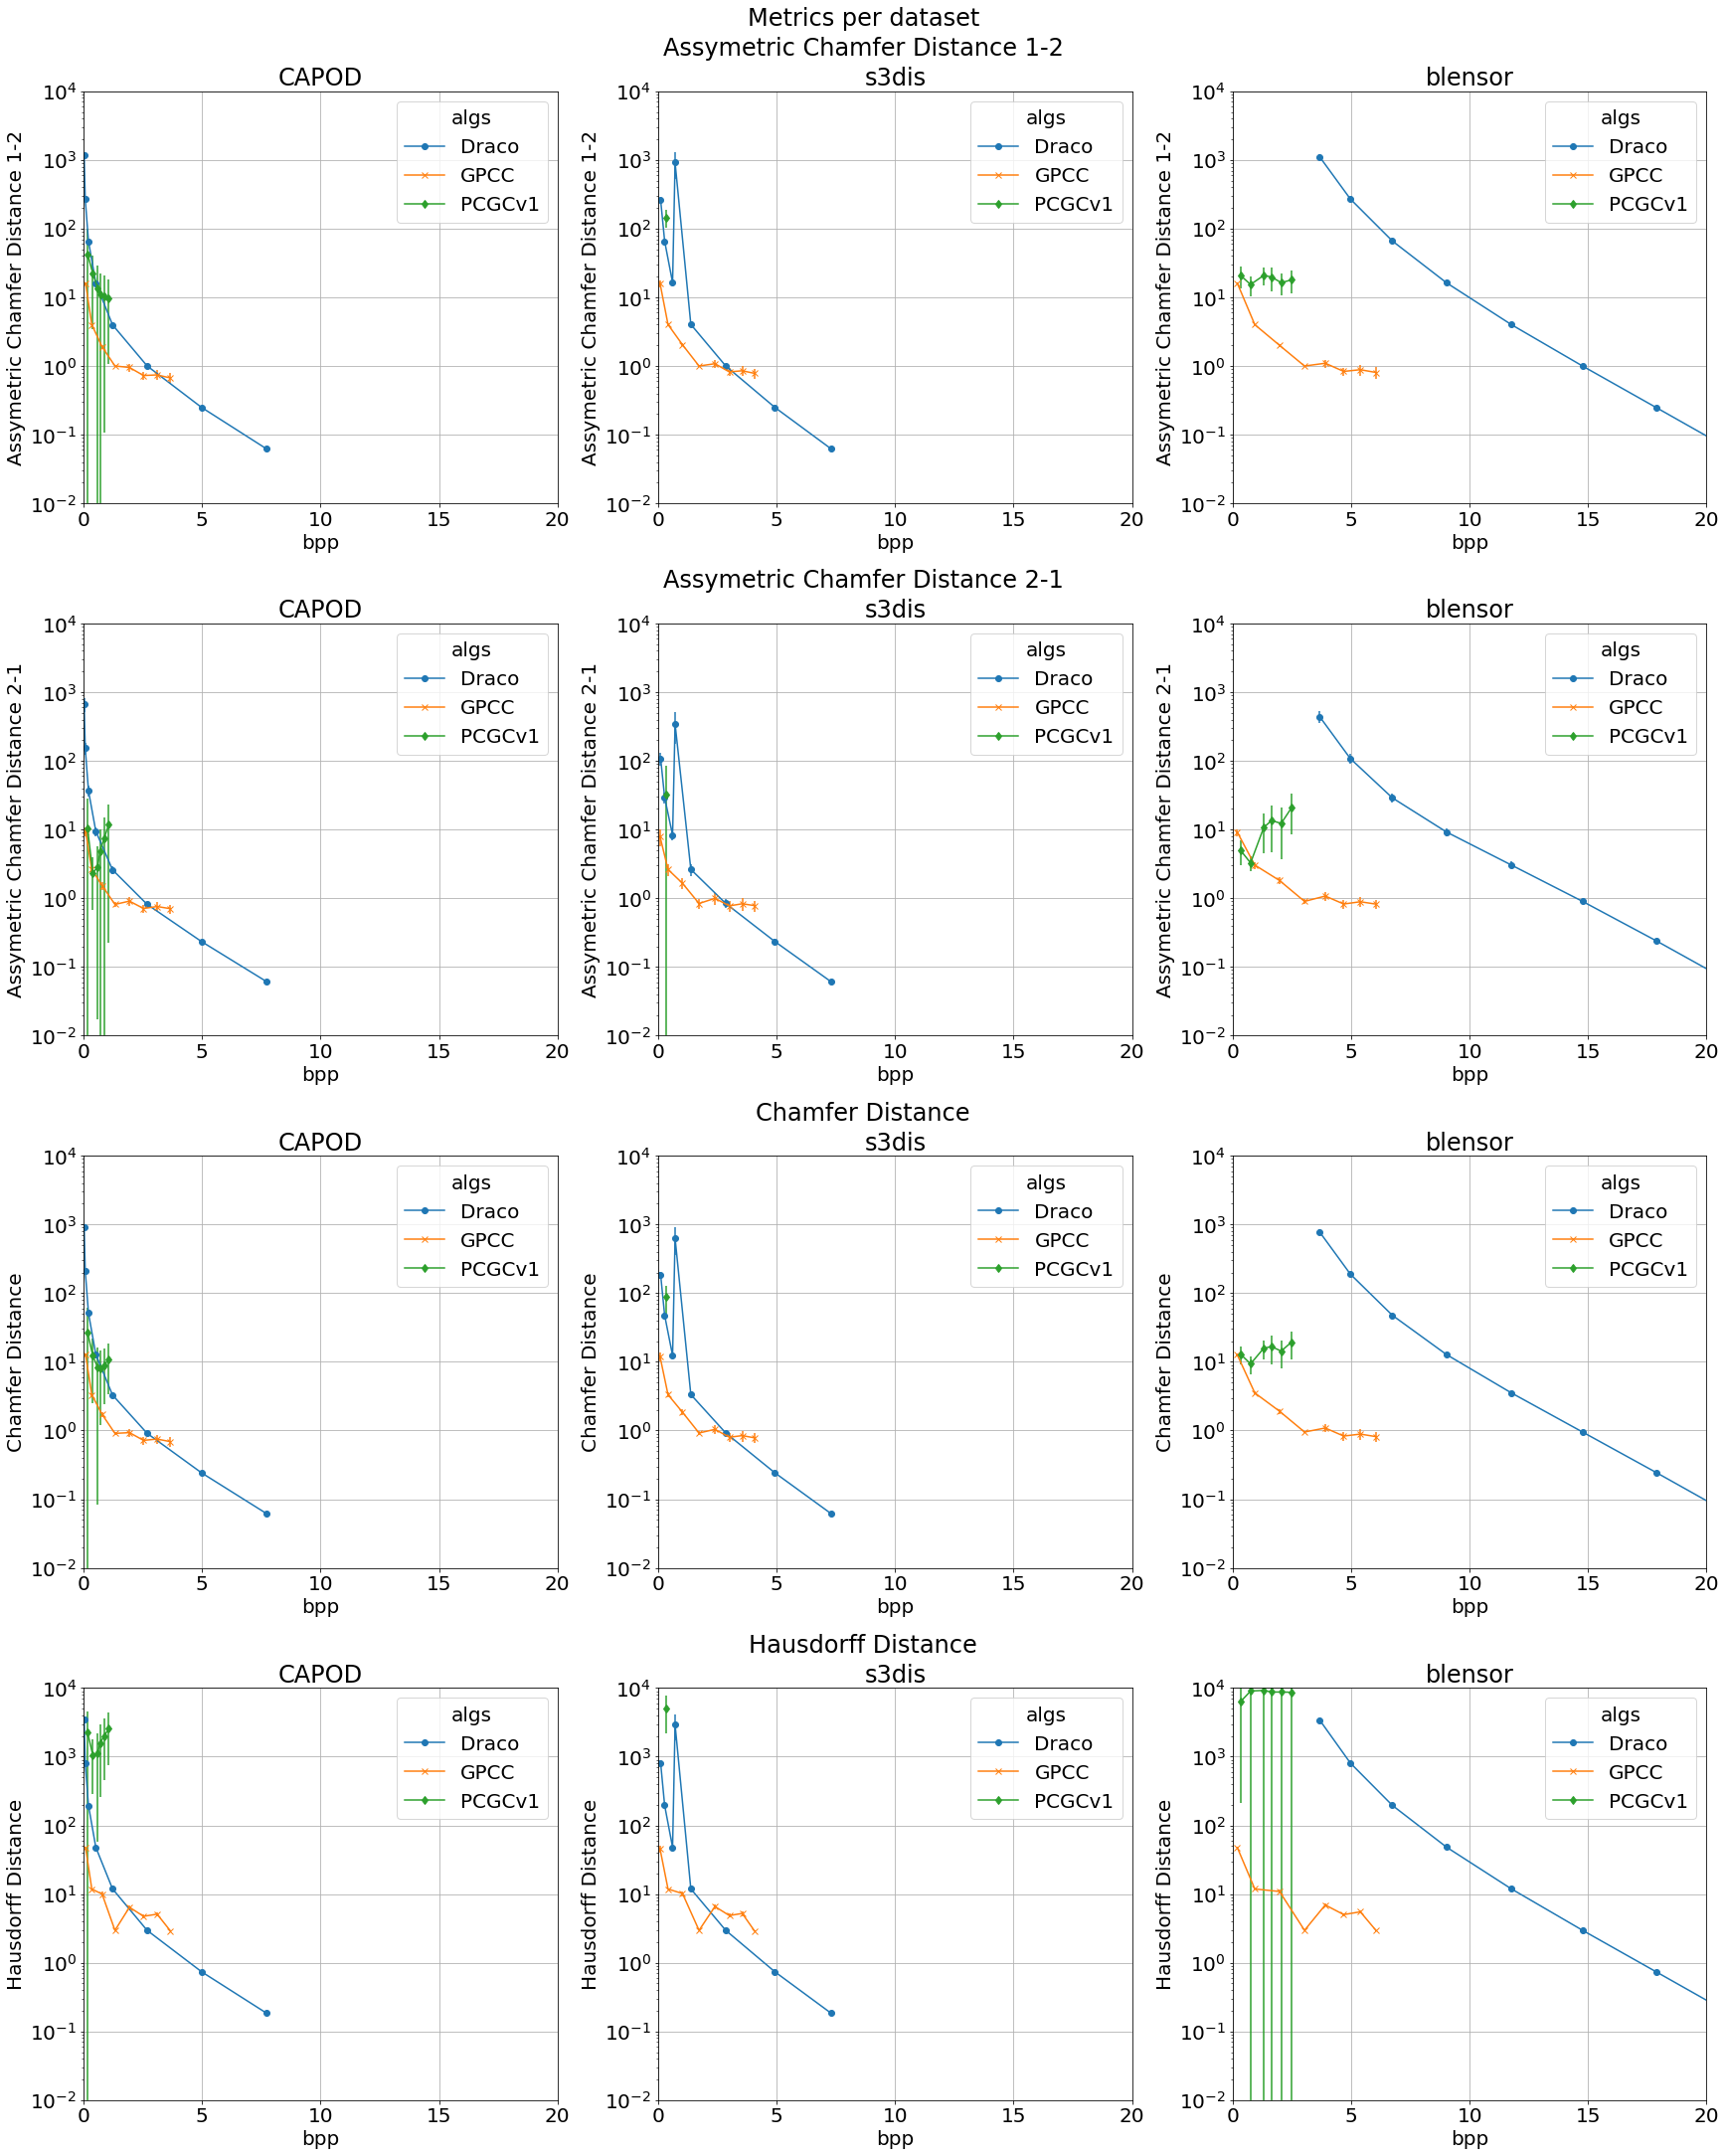

In [98]:
# try to recreate the metric/bpp graphs from the paper
# ACD to BPP per algorithm
summary = pd.read_csv("../PCCArena/experiments/summary.csv")

datasets = ["CAPOD", "s3dis", "blensor"]
#datasets = ["CAPOD", "CAPOD"]

col2label = {
    "acd12_p2pt": "Assymetric Chamfer Distance 1-2",
    "acd21_p2pt": "Assymetric Chamfer Distance 2-1",
    "cd_p2pt": "Chamfer Distance",
    "h_p2pt": "Hausdorff Distance"
}

relevant_cols = list(col2label.keys())
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(24)
fig.set_figheight(30)
fig.tight_layout()
fig.suptitle("Metrics per dataset")

alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d",
    "PCGCv2": "d",
    "GeoCNNv1": "x",
    "GeoCNNv2": "^"
}

subfigs = fig.subfigures(nrows=len(relevant_cols), ncols=1)

for i, subfig in enumerate(subfigs):
    col = relevant_cols[i]
    axs = subfig.subplots(nrows=1, ncols=len(datasets))
    subfig.suptitle(f'{col2label[col]}')
    for j, ax in enumerate(axs):
        dataset = datasets[j]
        filtered = summary[summary.datasets == dataset]
        groups = filtered.groupby(['algs', 'rate'])
        means = groups.mean()
        std = groups.std()
        std["bpp"] = means["bpp"]

        means = means.reset_index()
        std = std.reset_index()
        display(dataset, means)
    

   
        for alg in ['Draco', 'GPCC', 'PCGCv1']:
            _means = means[means["algs"] == alg]
            _std = std[std["algs"] == alg]
            pivoted_means = _means.pivot(index='bpp', columns='algs', values=col)
            pivoted_std = _std.pivot(index='bpp', columns='algs', values=col)
            pivoted_means.plot(ax=ax, title=dataset, kind="line", yerr=pivoted_std, marker=alg2marker[alg], xlim=(0, 20),ylim=(0.01, 10000), logy=True, ylabel=col2label[col], grid=True)

# fig.savefig("plots/pcc_acd.png", bbox_inches='tight', pad_inches=1)

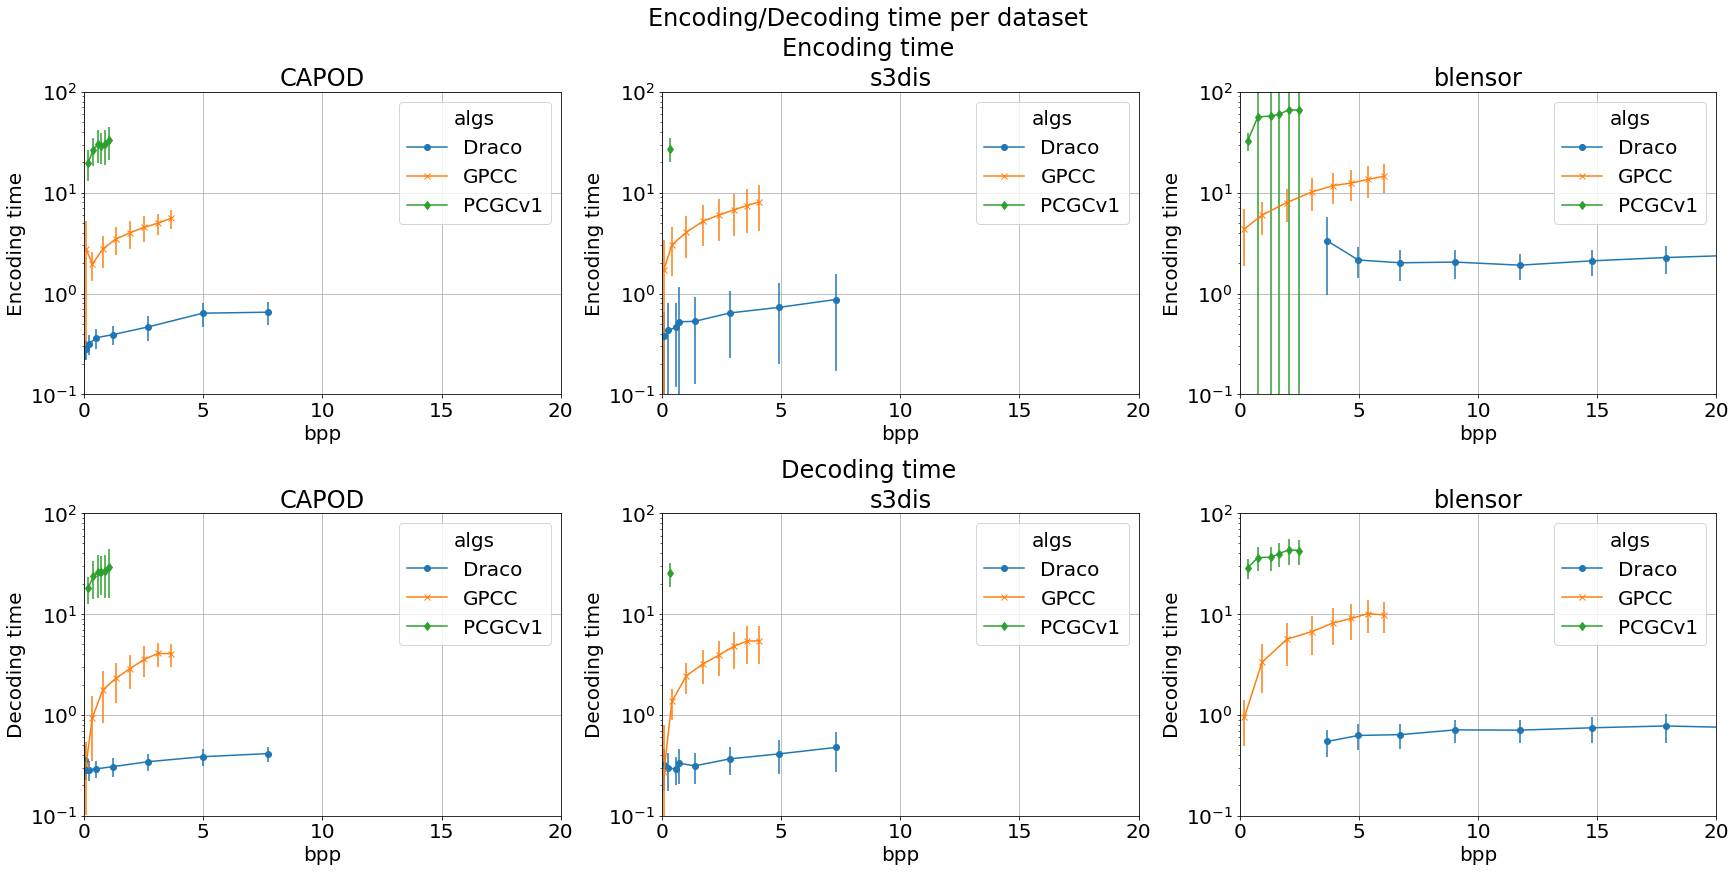

In [87]:
# try to recreate the metric/bpp graphs from the paper
# encoding time to bpp per algorithm
summary = pd.read_csv("../PCCArena/experiments/summary.csv")

datasets = ["CAPOD", "s3dis", "blensor"]

col2label = {
    "encT": "Encoding time",
    "decT": "Decoding time"    
}

relevant_cols = list(col2label.keys())
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(24)
fig.set_figheight(12)
fig.tight_layout()
fig.suptitle("Encoding/Decoding time per dataset")
subfigs = fig.subfigures(nrows=len(relevant_cols), ncols=1)


alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d",
    "PCGCv2": "d",
    "GeoCNNv1": "x",
    "GeoCNNv2": "^"
}
for i, subfig in enumerate(subfigs):
    col = relevant_cols[i]
    axs = subfig.subplots(nrows=1, ncols=len(datasets))
    subfig.suptitle(f'{col2label[col]}')
    for j, ax in enumerate(axs):
        dataset = datasets[j]
        filtered = summary[summary.datasets == dataset]
        groups = filtered.groupby(['algs', 'rate'])
        means = groups.mean()
        std = groups.std()
        std["bpp"] = means["bpp"]

        means = means.reset_index()
        std = std.reset_index()
    

   
        for alg in ['Draco', 'GPCC', 'PCGCv1']:
            _means = means[means["algs"] == alg]
            _std = std[std["algs"] == alg]
            pivoted_means = _means.pivot(index='bpp', columns='algs', values=col)
            pivoted_std = _std.pivot(index='bpp', columns='algs', values=col)
            pivoted_means.plot(ax=ax,kind="line",title=dataset, yerr=pivoted_std, marker=alg2marker[alg],xlim=(0,20), ylabel=col2label[col], logy=True, grid=True, ylim=(0.1, 100))
# fig.savefig("plots/pcc_enc_dec.png", bbox_inches='tight', pad_inches=1)